In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import re
import json
import copy

import nltk
from nltk.stem import WordNetLemmatizer
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

from tqdm import tqdm

In [2]:
from transformers import pipeline

In [3]:
import spacy

# Load nlp model
nlp = spacy.load('en_core_web_sm')

# Load Data

In [4]:
df_main = pd.read_csv('sample-mcd.csv', encoding='latin1')

print(df_main.info())
df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewer_id   100 non-null    int64 
 1   review_time   100 non-null    object
 2   review        100 non-null    object
 3   rating        100 non-null    object
 4   review_clean  99 non-null     object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB
None


,reviewer_id,review_time,review,rating,review_clean
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,look like someone spit food . normal transacti...
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,would mcdonalds . far food atmosphere go . sta...
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,make mobile order get speaker check line not m...
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5 stars,mc . crispy chicken sandwich customer service ...
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,"repeat order 3 time drive thru , still manage ..."


In [5]:
with open("meta-data.json", "r") as file:
    data = json.load(file)

data

{'0': {'reviewer_id': 1,
  'review_time': '2024-09-20',
  'rating': 1,
  'review': 'Why does it look like someone spit on my food?\nI had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.',
  'review_processed': "I had a normal transaction, but now I don't want to eat this. I'm trying not to think about what this milky white/clear substance is all over my food, and I'm sure I'm not coming back.",
  'aspect_sentiment': [{'term': 'food',
    'class': 'negative',
    'probability': [0.9742005467414856,
     0.0233919695019722,
     0.002407489577308297],
    'context': ["I'm trying not to think about what this milky white/clear substance is all over my food, and I'm sure I'm not coming back."]},
   {'term': 'substance',
    'class': 'negative',
    'probability': [0.9821223020553589,
     0.0007803093758411705,
     0.0170973930507898

In [6]:
df = pd.DataFrame.from_dict(data, orient='index')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviewer_id       100 non-null    int64 
 1   review_time       100 non-null    object
 2   rating            100 non-null    int64 
 3   review            100 non-null    object
 4   review_processed  100 non-null    object
 5   aspect_sentiment  100 non-null    object
dtypes: int64(2), object(4)
memory usage: 5.5+ KB
None


,reviewer_id,review_time,rating,review,review_processed,aspect_sentiment
0,1,2024-09-20,1,Why does it look like someone spit on my food?...,"I had a normal transaction, but now I don't wa...","[{'term': 'food', 'class': 'negative', 'probab..."
1,2,2024-12-15,4,It'd McDonalds. It is what it is as far as the...,It's what it is as far as the food and atmosph...,"[{'term': 'staff', 'class': 'positive', 'proba..."
2,3,2024-12-15,1,Made a mobile order got to the speaker and che...,I made a mobile order got to the speaker and c...,"[{'term': 'speaker', 'class': 'neutral', 'prob..."
3,4,2024-11-20,5,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,"[{'term': 'service', 'class': 'positive', 'pro..."
4,5,2024-10-20,1,"I repeat my order 3 times in the drive thru, a...",I repeat my order three times in the drive thr...,"[{'term': 'fries', 'class': 'positive', 'proba..."


# Aspect Classification

In [7]:
aspects = {}
text = ""
for items in df['aspect_sentiment'].values:
    for item in items:
        term = item.get('term')
        text = text + term + " " 
        if term not in aspects.keys():
            aspects[term] = 1
        else:
            aspects[term] = aspects[term] + 1
aspects

{'food': 15,
 'substance': 1,
 'milky': 1,
 'staff': 12,
 'atmosphere': 1,
 'speaker': 1,
 'service': 10,
 'crisp': 1,
 'fries': 6,
 'meal': 5,
 'filet of fish': 1,
 'wait': 4,
 'door': 1,
 'cookies': 1,
 'hamburg': 1,
 'customer service': 3,
 'sweet tea': 1,
 'coffee': 2,
 'sauce': 1,
 'chicken': 1,
 'orders': 3,
 'fast food': 3,
 'drinks': 2,
 'food items': 1,
 'waits': 1,
 'night crew': 1,
 'morning crew': 1,
 'sausage': 1,
 'egg': 1,
 'syrup': 1,
 'butter': 1,
 'breakfast with hot cakes': 1,
 'utensils': 1,
 'condiments': 1,
 'drink cups': 1,
 'chicken sandwich': 1,
 'tables': 1,
 'din': 1,
 'cookie': 1,
 'apples strawberries': 1,
 'bag of food': 1,
 'drink': 4,
 'smooth': 1,
 'hash browns': 1,
 'strawberry banana smoothies': 1,
 'bathrooms': 1,
 'lobby': 2,
 'order taker': 1,
 'money': 1,
 'caffeine': 1,
 'card': 1,
 'ice cream': 2,
 'mcdonald': 5,
 'employees': 4,
 'sausage biscuit': 1,
 'plain': 1,
 'room': 1,
 'caramel mocha': 1,
 'order menu': 1,
 'thru line': 1,
 'drive': 4,


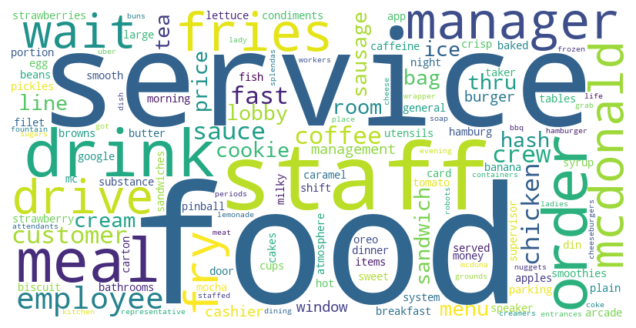

In [8]:
from wordcloud import WordCloud


# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [9]:
classification = {
    "Food and Menu Items": [
        "food",
        "fast food",
        "sandwich",
        "crispy chicken sandwich",
        "fries",
        "meal",
        "filet of fish",
        "cookies",
        "hamburg",
        "chicken mcnuggets",
        "chicken",
        "food items",
        "sausage",
        "egg",
        "breakfast with hot cakes",
        "food burger",
        "chicken sandwich",
        "apples strawberries",
        "bag of food",
        "drink",
        "water",
        "strawberry banana smoothies",
        "smoothie",
        "hash brownsies",
        "ice cream",
        "taste",
        "pounder",
        "quarter",
        "double",
        "sausage biscuit",
        "caramel mocha",
        "spicy chicken sandwich",
        "chicken sandwiches",
        "fry",
        "large",
        "lettuce and tomato",
        "menu",
        "lunch",
        "breakfast",
        "nuggets",
        "burgers",
        "cheeseburgers",
        "frozen lemonade",
        "burger",
        "meals",
        "baked beans",
        "oreo mcry",
        "drinks",
        "order menu",
        "order",
        "coke",
    ],
    "Condiments": [
        "sauce",
        "condiments",
        "pickles",
        "bbq sauce",
        "cream",
        "sugars",
        "creamers",
        "splendas",
        "butter",
        "syrup"
    ],
    "Service and Staff": [
        "staff",
        "customer service",
        "manager",
        "night crew",
        "morning crew",
        "order taker",
        "morning staff",
        "evening staff",
        "employees",
        "supervisor",
        "shift manager",
        "cashier",
        "worker",
        "cooks",
        "kitchen staff",
        "attendant",
        "attendants",
        "crew",
        "workers"
    ],
    "Experience and Environment": [
        "atmosphere",
        "service",
        "wait",
        "door",
        "tables",
        "lobby",
        "bathrooms",
        "area",
        "drive thru line",
        "meal periods",
        "time management",
        "teamwork",
        "appearance",
        "drive",
        "dinner",
        "orders",
        "pinball arcade"
    ],
    "Packaging": [
        "cup",
        "drink cups",
        "carton",
        "fry containers",
        "hamburger wrapper",
        "bag"
    ],
    "Pricing and Value": [
        "price",
        "price range",
        "prices",
        "money"
    ],
    "Miscellaneous": [
        "substance",
        "speaker",
        "general",
        "thru line",
        "google",
        "management",
        "portion",
        "messed",
        "robots",
        "extra",
        "heat lamp",
        "food window",
        "kitchen",
        "coffee grounds",
        "lady",
        "places",
        "entrances",
        "uber",
        "dish soap",
        "br"
    ]
}


In [10]:
def get_key(dictionary, value):
    for k, v in dictionary.items():
        if value in v:
            return k
    return 'Miscellaneous'
            
def generate_topics(dictionary):
    return list(dictionary.keys())

In [11]:
# Save topic-aspect dataframe

# Padding dictionary
def padding(dict_: dict):
    result = {}
    target_length = max([len(x) for x in dict_.values()])
    for k, v in dict_.items():
        result[k] = v + [np.nan] * (target_length - len(v))
    return result


padded_aspects = padding(classification)

df_topic_aspect = pd.DataFrame.from_dict(padded_aspects)

df_topic_aspect

,Food and Menu Items,Condiments,Service and Staff,Experience and Environment,Packaging,Pricing and Value,Miscellaneous
0,food,sauce,staff,atmosphere,cup,price,substance
1,fast food,condiments,customer service,service,drink cups,price range,speaker
2,sandwich,pickles,manager,wait,carton,prices,general
3,crispy chicken sandwich,bbq sauce,night crew,door,fry containers,money,thru line
4,fries,cream,morning crew,tables,hamburger wrapper,NaN,google
5,meal,sugars,order taker,lobby,bag,NaN,management
6,filet of fish,creamers,morning staff,bathrooms,NaN,NaN,portion
7,cookies,splendas,evening staff,area,NaN,NaN,messed
8,hamburg,butter,employees,drive thru line,NaN,NaN,robots
9,chicken mcnuggets,syrup,supervisor,meal periods,NaN,NaN,extra


In [12]:
# Save to excel

df_topic_aspect.to_excel("table/topic_aspect.xlsx", index=False)

# Table Main

In [13]:
df.head()

,reviewer_id,review_time,rating,review,review_processed,aspect_sentiment
0,1,2024-09-20,1,Why does it look like someone spit on my food?...,"I had a normal transaction, but now I don't wa...","[{'term': 'food', 'class': 'negative', 'probab..."
1,2,2024-12-15,4,It'd McDonalds. It is what it is as far as the...,It's what it is as far as the food and atmosph...,"[{'term': 'staff', 'class': 'positive', 'proba..."
2,3,2024-12-15,1,Made a mobile order got to the speaker and che...,I made a mobile order got to the speaker and c...,"[{'term': 'speaker', 'class': 'neutral', 'prob..."
3,4,2024-11-20,5,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,"[{'term': 'service', 'class': 'positive', 'pro..."
4,5,2024-10-20,1,"I repeat my order 3 times in the drive thru, a...",I repeat my order three times in the drive thr...,"[{'term': 'fries', 'class': 'positive', 'proba..."


In [14]:
topic_json = {k: 0 for k in list(classification.keys()) + ["Miscellaneous"]}
topic_json

{'Food and Menu Items': 0,
 'Condiments': 0,
 'Service and Staff': 0,
 'Experience and Environment': 0,
 'Packaging': 0,
 'Pricing and Value': 0,
 'Miscellaneous': 0}

In [15]:
list(aspects.keys())

['food',
 'substance',
 'milky',
 'staff',
 'atmosphere',
 'speaker',
 'service',
 'crisp',
 'fries',
 'meal',
 'filet of fish',
 'wait',
 'door',
 'cookies',
 'hamburg',
 'customer service',
 'sweet tea',
 'coffee',
 'sauce',
 'chicken',
 'orders',
 'fast food',
 'drinks',
 'food items',
 'waits',
 'night crew',
 'morning crew',
 'sausage',
 'egg',
 'syrup',
 'butter',
 'breakfast with hot cakes',
 'utensils',
 'condiments',
 'drink cups',
 'chicken sandwich',
 'tables',
 'din',
 'cookie',
 'apples strawberries',
 'bag of food',
 'drink',
 'smooth',
 'hash browns',
 'strawberry banana smoothies',
 'bathrooms',
 'lobby',
 'order taker',
 'money',
 'caffeine',
 'card',
 'ice cream',
 'mcdonald',
 'employees',
 'sausage biscuit',
 'plain',
 'room',
 'caramel mocha',
 'order menu',
 'thru line',
 'drive',
 'dinner',
 'parking',
 'pinball arcade',
 'price',
 'pickles',
 'google',
 'supervisor',
 'general',
 'tomato',
 'chicken sandwiches',
 'fry',
 'large',
 'lettuce',
 'menu',
 'app',
 's

**Topic Classification**

In [16]:
# Topic records

records = []
for _, row in df.iterrows():
    record = {'reviewer_id': row['reviewer_id']}
    items = row['aspect_sentiment']
    record.update(topic_json.copy())
    for item in items:
        term = item['term']
        topic = get_key(classification, term)
        record[topic] = 1
    records.append(record)

records

[{'reviewer_id': 1,
  'Food and Menu Items': 1,
  'Condiments': 0,
  'Service and Staff': 0,
  'Experience and Environment': 0,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 1},
 {'reviewer_id': 2,
  'Food and Menu Items': 1,
  'Condiments': 0,
  'Service and Staff': 1,
  'Experience and Environment': 1,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 0},
 {'reviewer_id': 3,
  'Food and Menu Items': 0,
  'Condiments': 0,
  'Service and Staff': 0,
  'Experience and Environment': 0,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 1},
 {'reviewer_id': 4,
  'Food and Menu Items': 0,
  'Condiments': 0,
  'Service and Staff': 0,
  'Experience and Environment': 1,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 1},
 {'reviewer_id': 5,
  'Food and Menu Items': 1,
  'Condiments': 0,
  'Service and Staff': 0,
  'Experience and Environment': 0,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 0},
 {'reviewer_id': 6,
  'Fo

**Save Table per Topic**

In [17]:
topic_df = pd.DataFrame.from_dict(records)

topic_df.head()

,reviewer_id,Food and Menu Items,Condiments,Service and Staff,Experience and Environment,Packaging,Pricing and Value,Miscellaneous
0,1,1,0,0,0,0,0,1
1,2,1,0,1,1,0,0,0
2,3,0,0,0,0,0,0,1
3,4,0,0,0,1,0,0,1
4,5,1,0,0,0,0,0,0


In [18]:
def formatting_aspect(items):
    format = ""
    for i, item in enumerate(items):
        term = item.get('term')
        sentiment = item.get('class')
        format += f"● {term}: {sentiment}"
        if i != len(items) - 1:
            format += "\n"
    return format

def generate_table(df: pd.DataFrame, topic_df: pd.DataFrame, topic: str):
    drop = ['review_processed']
    mask = topic_df[topic_df[topic] == 1]['reviewer_id'].values
    result = df[df['reviewer_id'].isin(mask)].copy()
    result['aspect_sentiment'] = result['aspect_sentiment'].apply(formatting_aspect)
    result['topic'] = [topic] * result.shape[0]
    result = result.drop(drop, axis=1).sort_values(by='review_time').reset_index(drop=True)

    return result

In [19]:
topics = generate_topics(classification)

frames = []
for topic in topics:
    temp = generate_table(df, topic_df, topic)
    frames.append(temp)
    # Save to excel
    # temp.to_excel(f"table/main_mcd_{topic}.xlsx", index=False)

In [20]:
df_main = pd.concat(frames).sort_values(by='review_time')

df_main.head()

,reviewer_id,review_time,rating,review,aspect_sentiment,topic
0,84,2019-12-20,3,Decent McDonald's location. The team here has...,● food: positive\n● meal: neutral\n● meal peri...,Food and Menu Items
2,74,2019-12-20,1,waited in the drive through for over half an h...,● service: negative\n● wait: negative,Experience and Environment
0,93,2019-12-20,1,Attempted to go through the drive thru at 430 ...,● kitchen: neutral\n● drive: neutral,Miscellaneous
0,93,2019-12-20,1,Attempted to go through the drive thru at 430 ...,● kitchen: neutral\n● drive: neutral,Experience and Environment
1,84,2019-12-20,3,Decent McDonald's location. The team here has...,● food: positive\n● meal: neutral\n● meal peri...,Experience and Environment


In [21]:
# Save to excel
df_main.to_excel("table/main_mcd.xlsx", index=False)

# Table Aspects

In [22]:
df.head()

,reviewer_id,review_time,rating,review,review_processed,aspect_sentiment
0,1,2024-09-20,1,Why does it look like someone spit on my food?...,"I had a normal transaction, but now I don't wa...","[{'term': 'food', 'class': 'negative', 'probab..."
1,2,2024-12-15,4,It'd McDonalds. It is what it is as far as the...,It's what it is as far as the food and atmosph...,"[{'term': 'staff', 'class': 'positive', 'proba..."
2,3,2024-12-15,1,Made a mobile order got to the speaker and che...,I made a mobile order got to the speaker and c...,"[{'term': 'speaker', 'class': 'neutral', 'prob..."
3,4,2024-11-20,5,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,"[{'term': 'service', 'class': 'positive', 'pro..."
4,5,2024-10-20,1,"I repeat my order 3 times in the drive thru, a...",I repeat my order three times in the drive thr...,"[{'term': 'fries', 'class': 'positive', 'proba..."


In [23]:
# Output: id, date, aspect, sentiment, topic
def recording_aspect(row):
    records = []
    id_ = row['reviewer_id']
    date_ = row['review_time']
    items = row['aspect_sentiment']
    rating = row['rating']
    
    for item in items:
        aspect = item.get('term')
        aspect = nlp(aspect)[0:].lemma_
        sentiment = item.get('class')
        topic = get_key(classification, aspect)
        records.append({'reviewer_id': id_, 'review_time': date_, 'aspect':aspect, 'sentiment': sentiment, 'topic': topic, 'rating': rating})
    return records

In [24]:
records = []

for _, row in df.iterrows():
    records += recording_aspect(row)

records

[{'reviewer_id': 1,
  'review_time': '2024-09-20',
  'aspect': 'food',
  'sentiment': 'negative',
  'topic': 'Food and Menu Items',
  'rating': 1},
 {'reviewer_id': 1,
  'review_time': '2024-09-20',
  'aspect': 'substance',
  'sentiment': 'negative',
  'topic': 'Miscellaneous',
  'rating': 1},
 {'reviewer_id': 1,
  'review_time': '2024-09-20',
  'aspect': 'milky',
  'sentiment': 'negative',
  'topic': 'Miscellaneous',
  'rating': 1},
 {'reviewer_id': 2,
  'review_time': '2024-12-15',
  'aspect': 'staff',
  'sentiment': 'positive',
  'topic': 'Service and Staff',
  'rating': 4},
 {'reviewer_id': 2,
  'review_time': '2024-12-15',
  'aspect': 'atmosphere',
  'sentiment': 'neutral',
  'topic': 'Experience and Environment',
  'rating': 4},
 {'reviewer_id': 2,
  'review_time': '2024-12-15',
  'aspect': 'food',
  'sentiment': 'neutral',
  'topic': 'Food and Menu Items',
  'rating': 4},
 {'reviewer_id': 3,
  'review_time': '2024-12-15',
  'aspect': 'speaker',
  'sentiment': 'neutral',
  'topic

In [25]:
df_record = pd.DataFrame.from_dict(records)

# Create pivot table
df_aspect = (
    df_record.groupby(["aspect", "review_time", "sentiment"])['review_time']
    .count()
    .unstack("sentiment", fill_value=0)
    .sort_values(by='review_time')
).reset_index()

df_aspect['total'] = df_aspect['negative'] + df_aspect['positive'] + df_aspect['neutral']

# Fix datetime
# Convert review_time to datetime
df_aspect['review_time'] = pd.to_datetime(df_aspect['review_time'])

# Extract year and month
df_aspect['month'] = df_aspect['review_time'].apply(lambda x: x.replace(day=1).date())
df_aspect['year'] = df_aspect['review_time'].apply(lambda x: x.replace(day=1, month=1).date())
df_aspect['review_time'] = df_aspect['review_time'].apply(lambda x: x.date())

df_aspect = df_aspect.rename_axis(index=None, columns=None)

# Identify categorical and date columns
categorical_date_columns = ['aspect', 'review_time', 'year', 'month']

# Identify numeric columns
numeric_columns = [col for col in df_aspect.columns if col not in categorical_date_columns]

df_aspect = df_aspect[categorical_date_columns + numeric_columns]

df_aspect

,aspect,review_time,year,month,negative,neutral,positive,total
0,meal period,2019-12-20,2019-01-01,2019-12-01,0,1,0,1
1,wait,2019-12-20,2019-01-01,2019-12-01,1,0,0,1
2,meal,2019-12-20,2019-01-01,2019-12-01,0,1,0,1
3,kitchen,2019-12-20,2019-01-01,2019-12-01,0,1,0,1
4,service,2019-12-20,2019-01-01,2019-12-01,1,0,0,1
...,...,...,...,...,...,...,...,...
180,speaker,2024-12-15,2024-01-01,2024-12-01,0,1,0,1
181,food,2024-12-15,2024-01-01,2024-12-01,0,1,0,1
182,atmosphere,2024-12-15,2024-01-01,2024-12-01,0,1,0,1
183,door,2024-12-17,2024-01-01,2024-12-01,1,0,0,1


**Save Table per Aspect**

In [26]:
df_aspect.to_excel("table/aspect-mcd.xlsx", index=False)

**Mapping Topic-Aspect**

In [27]:
df_aspect['topic'] = df_aspect['aspect'].apply(lambda x: get_key(classification, x))

df_aspect.head()

,aspect,review_time,year,month,negative,neutral,positive,total,topic
0,meal period,2019-12-20,2019-01-01,2019-12-01,0,1,0,1,Miscellaneous
1,wait,2019-12-20,2019-01-01,2019-12-01,1,0,0,1,Experience and Environment
2,meal,2019-12-20,2019-01-01,2019-12-01,0,1,0,1,Food and Menu Items
3,kitchen,2019-12-20,2019-01-01,2019-12-01,0,1,0,1,Miscellaneous
4,service,2019-12-20,2019-01-01,2019-12-01,1,0,0,1,Experience and Environment


# Table Trend

In [28]:
df_record.head()

,reviewer_id,review_time,aspect,sentiment,topic,rating
0,1,2024-09-20,food,negative,Food and Menu Items,1
1,1,2024-09-20,substance,negative,Miscellaneous,1
2,1,2024-09-20,milky,negative,Miscellaneous,1
3,2,2024-12-15,staff,positive,Service and Staff,4
4,2,2024-12-15,atmosphere,neutral,Experience and Environment,4


In [29]:
# Create trend dataframe

temp_1 = ( df_record.groupby(["topic", "review_time"])
    .agg({'rating': ['sum', 'count']})
    .sort_values(by='review_time')
).reset_index()

temp_1.columns = ['_'.join(col).strip() if len(col[-1]) > 0 else col[0] for col in temp_1.columns.values]

temp_2 = (
    df_record.groupby(["topic", "review_time", "sentiment"])['review_time']
    .count()
    .unstack("sentiment", fill_value=0)
    .sort_values(by='review_time')
).reset_index()

df_trend = temp_1.merge(temp_2, on=['topic', 'review_time'])
df_trend['total'] = df_trend['negative'] + df_trend['positive'] + df_trend['neutral']

df_trend.head()

,topic,review_time,rating_sum,rating_count,negative,neutral,positive,total
0,Food and Menu Items,2019-12-20,6,2,0,1,1,2
1,Experience and Environment,2019-12-20,3,3,2,1,0,3
2,Miscellaneous,2019-12-20,4,2,0,2,0,2
3,Food and Menu Items,2020-12-20,6,2,0,1,1,2
4,Pricing and Value,2020-12-20,1,1,1,0,0,1


In [30]:
# Fix datetime
# Convert review_time to datetime
df_trend['review_time'] = pd.to_datetime(df_trend['review_time'])

# Extract year and month
df_trend['month'] = df_trend['review_time'].apply(lambda x: x.replace(day=1).date())
df_trend['year'] = df_trend['review_time'].apply(lambda x: x.replace(day=1, month=1).date())
df_trend['review_time'] = df_trend['review_time'].apply(lambda x: x.date())

# Identify categorical and date columns
categorical_date_columns = ['topic', 'review_time', 'year', 'month']

# Identify numeric columns
numeric_columns = [col for col in df_trend.columns if col not in categorical_date_columns]


df_trend = df_trend[categorical_date_columns + numeric_columns]

df_trend.head()

,topic,review_time,year,month,rating_sum,rating_count,negative,neutral,positive,total
0,Food and Menu Items,2019-12-20,2019-01-01,2019-12-01,6,2,0,1,1,2
1,Experience and Environment,2019-12-20,2019-01-01,2019-12-01,3,3,2,1,0,3
2,Miscellaneous,2019-12-20,2019-01-01,2019-12-01,4,2,0,2,0,2
3,Food and Menu Items,2020-12-20,2020-01-01,2020-12-01,6,2,0,1,1,2
4,Pricing and Value,2020-12-20,2020-01-01,2020-12-01,1,1,1,0,0,1


**Save Table Trend**

In [32]:
df_trend.to_excel("table/trend.xlsx", index=False)

# Prepare Table for SWOT Analysis

In [33]:
swot_json = {k: "" for k in list(classification.keys()) + ["Miscellaneous"]}
swot_json

{'Food and Menu Items': '',
 'Condiments': '',
 'Service and Staff': '',
 'Experience and Environment': '',
 'Packaging': '',
 'Pricing and Value': '',
 'Miscellaneous': ''}

In [34]:
for items in df['aspect_sentiment'].values:
    for item in items:
        if len(item) == 0:
            continue
        term = item.get('term')
        context = item.get('context')
        if len(context) > 0:
            context = context[0]
            class_ = get_key(classification, term)
            if context not in swot_json[class_]:
                swot_json[class_] = swot_json[class_] + "- " + context + "\n"

df_context_topic = pd.DataFrame.from_dict(swot_json, 'index', columns=['context']).T
df_context_topic

,Food and Menu Items,Condiments,Service and Staff,Experience and Environment,Packaging,Pricing and Value,Miscellaneous
context,- I'm trying not to think about what this milk...,- The restaurant gave me a hard time about ext...,"- The staff are friendly, accommodating, and a...",- It's what it is as far as the food and atmos...,- One of the drink cups were not filled proper...,- I just don't go here anymore to avoid the st...,- I'm trying not to think about what this milk...


In [35]:
df_context_topic.to_excel("table/context_table.xlsx", index=False)

PROMPT SUMMARIZE FORMAT:

Descriptive sentiment summary with bullet point format only about "topic": <text>

# Exploratory Data Analysis

**Table Trend**

In [36]:
# Distribution review

df_trend.head()

,topic,review_time,year,month,rating_sum,rating_count,negative,neutral,positive,total
0,Food and Menu Items,2019-12-20,2019-01-01,2019-12-01,6,2,0,1,1,2
1,Experience and Environment,2019-12-20,2019-01-01,2019-12-01,3,3,2,1,0,3
2,Miscellaneous,2019-12-20,2019-01-01,2019-12-01,4,2,0,2,0,2
3,Food and Menu Items,2020-12-20,2020-01-01,2020-12-01,6,2,0,1,1,2
4,Pricing and Value,2020-12-20,2020-01-01,2020-12-01,1,1,1,0,0,1


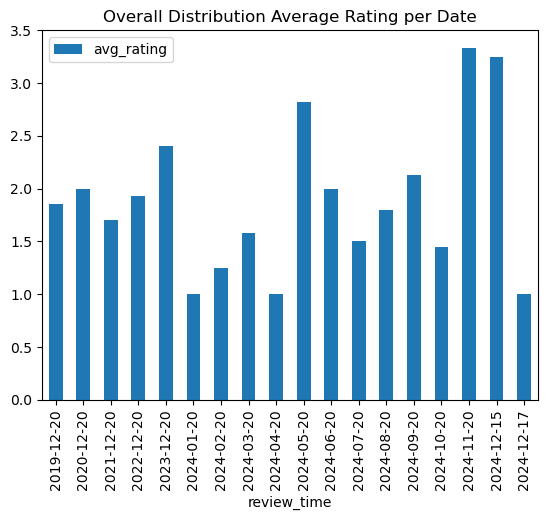

In [37]:
temp = df_trend.groupby('review_time').agg({'rating_sum': 'sum', 'rating_count': 'sum'})
temp['avg_rating'] = (temp['rating_sum'] / temp['rating_count']).fillna(0)

temp.drop(['rating_sum', 'rating_count'], axis=1).plot(kind='bar', title="Overall Distribution Average Rating per Date")
plt.show()

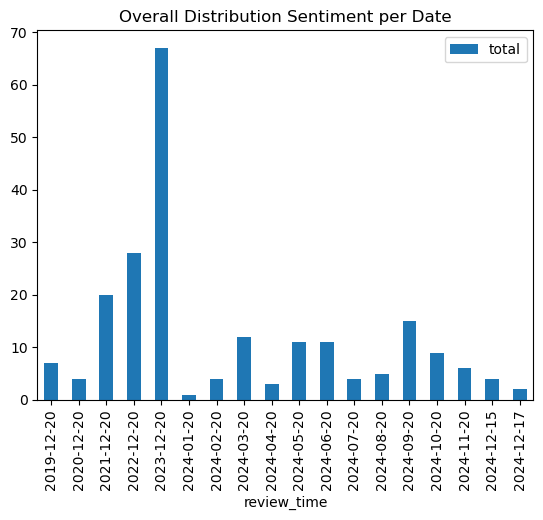

In [38]:
df_trend.groupby('review_time').agg({'total':'sum'}).plot(kind='bar', title="Overall Distribution Sentiment per Date")
plt.show()

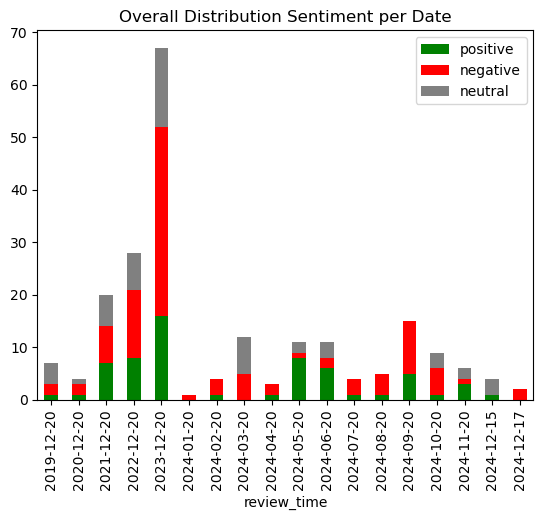

In [39]:
df_trend\
    .groupby('review_time')\
    .agg({'positive':'sum', 
          'negative':'sum',
          'neutral': 'sum'})\
    .plot(kind='bar', 
          title="Overall Distribution Sentiment per Date",
          stacked=True, 
          color=['green', 'red', 'gray'])

plt.show()

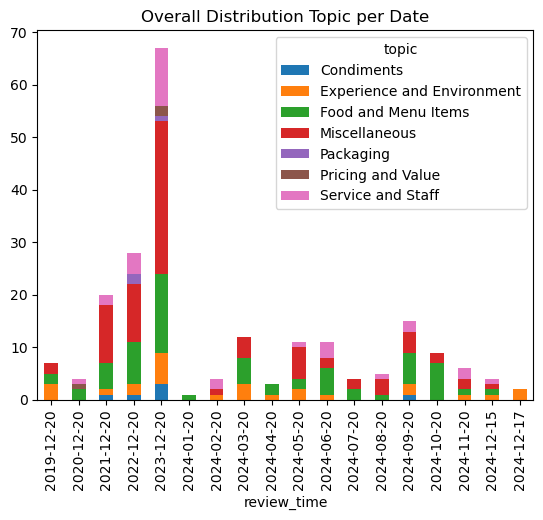

In [40]:
df_trend\
    .groupby(['review_time', 'topic'])\
    .agg({'total': 'sum'})\
    .rename({'total': 'count'}, axis=1)\
    .reset_index()\
    .pivot(index='review_time', columns='topic', values='count')\
    .fillna(0)\
    .plot(kind='bar', stacked=True, title='Overall Distribution Topic per Date')

plt.show()

**Table Aspect**

In [41]:
topics = generate_topics(classification)

print(topics)

['Food and Menu Items', 'Condiments', 'Service and Staff', 'Experience and Environment', 'Packaging', 'Pricing and Value', 'Miscellaneous']


In [42]:
# VARIABLES
FROM_DATE = "2019-12-01"
TO_DATE = "2024-01-01"
TOPIC = "Food and Menu Items"

MIN_DATE = np.min(df_trend['review_time'])
FROM_DATE = pd.to_datetime(MIN_DATE).date() if len(FROM_DATE) == 0 else pd.to_datetime(FROM_DATE).date()


MAX_DATE = np.max(df_trend['review_time'])
TO_DATE = pd.to_datetime(MIN_DATE).date() if len(TO_DATE) == 0 else pd.to_datetime(TO_DATE).date()

In [43]:
df_aspect['review_time'] = df_aspect['review_time'].apply(lambda x: pd.to_datetime(x).date())
df_aspect.head()

,aspect,review_time,year,month,negative,neutral,positive,total,topic
0,meal period,2019-12-20,2019-01-01,2019-12-01,0,1,0,1,Miscellaneous
1,wait,2019-12-20,2019-01-01,2019-12-01,1,0,0,1,Experience and Environment
2,meal,2019-12-20,2019-01-01,2019-12-01,0,1,0,1,Food and Menu Items
3,kitchen,2019-12-20,2019-01-01,2019-12-01,0,1,0,1,Miscellaneous
4,service,2019-12-20,2019-01-01,2019-12-01,1,0,0,1,Experience and Environment


FROM_DATE:  2019-12-01
TO_DATE:  2024-01-01


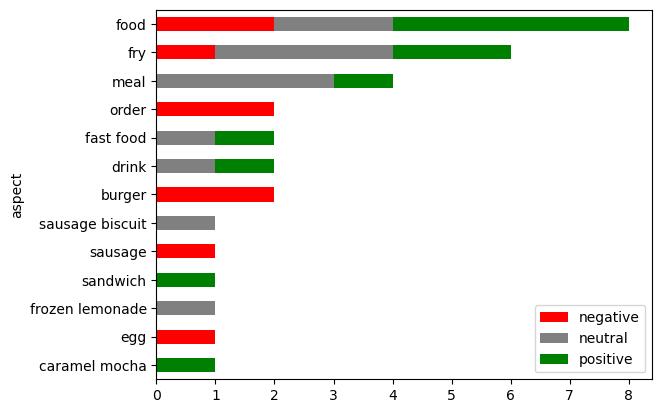

In [44]:
# Distribution per aspect

mask = (df_aspect['review_time'] >= FROM_DATE) & (df_aspect['review_time'] <= TO_DATE)
print("FROM_DATE: ", FROM_DATE)
print("TO_DATE: ", TO_DATE)

temp = df_aspect[mask].copy()
if TOPIC:
    mask = (temp['topic'] == TOPIC)
    temp = temp[mask].copy()
    
temp = temp.drop(['review_time', 'year', 'month', 'topic'], axis=1).groupby(['aspect']).sum().sort_values(by='total', ascending=True)

temp\
    .drop(['total'], axis=1)\
    .plot(kind='barh',
          stacked=True,
          color=['red', 'gray', 'green'])

plt.show()

**Table Main**

In [45]:
df_main['review_time'] = df_main['review_time'].apply(lambda x: pd.to_datetime(x).date())
df_main.head()

,reviewer_id,review_time,rating,review,aspect_sentiment,topic
0,84,2019-12-20,3,Decent McDonald's location. The team here has...,● food: positive\n● meal: neutral\n● meal peri...,Food and Menu Items
2,74,2019-12-20,1,waited in the drive through for over half an h...,● service: negative\n● wait: negative,Experience and Environment
0,93,2019-12-20,1,Attempted to go through the drive thru at 430 ...,● kitchen: neutral\n● drive: neutral,Miscellaneous
0,93,2019-12-20,1,Attempted to go through the drive thru at 430 ...,● kitchen: neutral\n● drive: neutral,Experience and Environment
1,84,2019-12-20,3,Decent McDonald's location. The team here has...,● food: positive\n● meal: neutral\n● meal peri...,Experience and Environment


In [46]:
pd.set_option('display.max_colwidth', 2000)

mask = (df_main['review_time'] >= FROM_DATE) & (df_main['review_time'] <= TO_DATE)
print("FROM_DATE: ", FROM_DATE)
print("TO_DATE: ", TO_DATE)

temp = df_main[mask].copy()
if TOPIC:
    mask = (temp['topic'] == TOPIC)
    temp = temp[mask].copy()

# if ASPECT:
    # mask = (temp['aspect'])

temp = temp[['review', 'aspect_sentiment', 'rating']].sort_values(by='rating', ascending=False)
temp

FROM_DATE:  2019-12-01
TO_DATE:  2024-01-01


,review,aspect_sentiment,rating
16,"The cashier's are very nice. Its very clean on the inside, and they get your food done fast",● food: positive\n● cashier: positive,5
4,"I would have given 5 stars, the evening manager is the nicest person I have seen and is definitely in charge of training her crew with constantly new help, in spite of this, everytime I have to return an order she goes back to the kitchen and patiently disassembles the sandwich and explains the proper way to make the sandwich in a spirit of education and with a cherry disposition. You can tell the children she works with respect her and look up to her, and yes, they might get things confused occasionally but I will continue to go there. 4 out of 5 stars",● sandwich: positive\n● crew: positive\n● evening manager: positive,4
18,"The line wS extremely big and was moving very slowly, plus they were out of apple pies and strawberry cream pies, but they gave me substitute cinnabun, the staff was very apologetic for being slow & they were out of pies, but it was middle of the night and they were extremely under-staffed.",● staff: negative\n● cookie: negative\n● apples strawberries: neutral,4
17,I go here all the time. Great staff.. NVR get my food wrong it's just always a line wrapped around lol that's why they ain't 5 stars. Most def customer service is better then the food but hey I just go for my kids because they love it so why not! Good customer service guys! Makes all the difference,● food: negative\n● service: negative,4
9,"The staff is very kind and the food is usually prepared in a timely manner, for this reason it'sone of my preferred location's. However the drive thru line can sometimes be an inconvenience as it can get very long and at times even block entrances.",● entrances: negative\n● drive thru line: negative\n● food: positive\n● staff: positive,4
0,"Decent McDonald's location. The team here has always been friendly. Drive thru can get pretty backed up during normal meal periods, so often it is better to go inside. Make sure you go close to regular meal periods for fresher food vs the ones under the heat lamp for a while. Store is always clean.",● food: positive\n● meal: neutral\n● meal periods: neutral,3
6,They run out of fry containers and constantly forget sauces. The dining room is still closed for some reason so have fun getting back in line for a sauce. Sometimes the fries aren't great which is a huge part of McDonald's. Come on guys...,● fries: negative\n● dining room: negative\n● fry containers: negative\n● sauces: negative,3
19,"Today, i was disappointed in that restaurant #11853 did not get me my FULL order, meaning I did not receive my condiments for my big breakfast with hot cakes. No butter, no syrup, and no utensils. Luckily this was a hiccup and not a regular thing. Oh, and the egg was half the size of the sausage.",● sausage: negative\n● egg: negative\n● syrup: negative\n● butter: negative\n● breakfast with hot cakes: neutral\n● utensils: negative\n● condiments: negative,3
14,"Me and my girlfriend came tonight to pick up our food after 11pm for a mobile order, they need a better system if you are walking on foot. The food tasted great, loved the McDonald's deal ordering from the app.",● app: neutral\n● mcdonald: positive\n● food: positive\n● system: positive,3
1,"This place is okay. It has these kiosks where you order, take a number, and they bring the food to your table. I ordered a frozen lemonade, paid for it, then sat down. I was there for a bit before someone came and told me they were out. I got a regular drink instead but it was too much trouble to get a refund for the difference. I'm not sure I like this new way.",● drink: positive\n● frozen lemonade: neutral,3
